# ReThink Media Twitter API

This notebook is for the development and exploration of code for ReThink Media's Twitter API Python interface. The main goals of this notebook are:

- Search Tweets: query, date (optional)
  - Past seven days
  - Past 30 days
  - Full archive
  - Language = English
- Collect Tweets in .csv file
- Add data visualization
  - Top hashtags, keywords, influencers
  - Volume over time for queries/topics

In [ ]:
# importing necessary modules
from dotenv import load_dotenv
import os
import json
import numpy as np
import pandas as pd
import tweepy

load_dotenv()

## Utility Functions

Functions for general use across the different analysis functions within the notebook.

In [3]:
# function to parse Twitter API v2 response into a DataFrame of Tweet data
def tweet_df(df, response, tweet_fields):
    
    users = response.includes['users']
    user_data = {user['id']: [user['public_metrics']['followers_count'], user['verified']] for user in users}
        
    # looping through each Tweet in response, parsing data
    for i in range(len(response.data)):
        tweet = response.data[i]
        tweet_id = tweet.id
        tweet_data = {}
        for field in tweet_fields:
            if tweet[field]:
                tweet_data[field] = tweet[field]
                
                # extracting hashtags from "entities" field and adding it as its own column
                if field == "entities":
                    try:
                        hashtag_data = tweet[field]['hashtags']
                        hashtags = [hashtag['tag'] for hashtag in hashtag_data]
                        tweet_data['entities_hashtags'] = hashtags
                    except KeyError:
                        tweet_data['entities_hashtags'] = None
                
                # separating metrics from "public_metrics" field and adding them as their own column
                if field == "public_metrics":
                    metrics = list(tweet[field].keys())
                    for metric in metrics:
                        tweet_data[metric] = tweet[field][metric]
                
            else:
                tweet_data[field] = None
                if field == "entities":
                    tweet_data['entities_hashtags'] = None
        
        # adding user data to DataFrame
        user = user_data[tweet['author_id']]
        tweet_data['followers_count'] = user[0]
        tweet_data['verified'] = user[1]
        
        df.loc[tweet_id] = tweet_data
    
    return df

In [4]:
# function to add follower counts to DataFrame of Tweet data
# designed to be called after the Tweet data has been parsed with tweet_df()
def author_data(api_2, df):
    num_users = 0
    author_ids = df["author_id"].unique().tolist()
    users = []
    while num_users < len(author_ids):
        
        # slicing tweet_ids since API v2 get_users only takes max 100 ID's per request
        try:
            slice_ids = author_ids[num_users:num_users+100]
        except IndexError:
            slice_ids = author_ids[num_users:]
        
        # retrieving user data through API v2, adding responses to users list
        user_fields = ["public_metrics", "verified"]
        response = api_2.get_users(ids=slice_ids, usernames=None, user_fields=user_fields)
        users.extend(response[0])
        num_users += len(response[0])
    
    # mapping author_id to follower counts and verified status, adding to DataFrame
    followers_count = {user['id']: user['public_metrics']['followers_count'] for user in users}
    verified = {user['id']: user['verified'] for user in users}
    df["author_followers_count"] = df["author_id"].map(followers_count)
    df["author_verified"] = df["author_id"].map(verified)
    
    return df

## Authentication

The variables below are what allow access to the Twitter API. I've defined them in a `.env` file, and I'm retrieving them with the code below. We then pass those variables in to a tweepy client in order to instantiate a Twitter API instance.

In [ ]:
# retrieving environment variables
consumer_key = os.getenv("API_KEY")
consumer_secret = os.getenv("API_KEY_SECRET")
bearer_token = os.getenv("BEARER_TOKEN")
access_token = os.getenv("ACCESS_TOKEN")
access_secret = os.getenv("ACCESS_SECRET")

In [ ]:
# Twitter API authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [5]:
# function to initialize Twitter API v1.1 instance (for 30-day and full archive search)
def init_api_1():
    
    # importing necessary modules and loading .env file
    from dotenv import load_dotenv
    import os
    import tweepy
    load_dotenv()
    
    # retrieving environment variables from .env file
    consumer_key = os.getenv("API_KEY")
    consumer_secret = os.getenv("API_KEY_SECRET")
    bearer_token = os.getenv("BEARER_TOKEN")
    access_token = os.getenv("ACCESS_TOKEN")
    access_secret = os.getenv("ACCESS_SECRET")
    
    # Twitter API authentication
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    
    # instantiating Twitter API v1.1 reference
    api_1 = tweepy.API(auth, wait_on_rate_limit=True)
    
    return api_1

In [6]:
# function to initialize Twitter API v2 instance (for 7-day search)
def init_api_2():
    # importing necessary modules and loading .env file
    from dotenv import load_dotenv
    import os
    import tweepy
    load_dotenv()
    
    # retrieving environment variables from .env file
    consumer_key = os.getenv("API_KEY")
    consumer_secret = os.getenv("API_KEY_SECRET")
    bearer_token = os.getenv("BEARER_TOKEN")
    access_token = os.getenv("ACCESS_TOKEN")
    access_secret = os.getenv("ACCESS_SECRET")
    
    # instantiating Twitter API v2 reference
    api_2 = tweepy.Client(bearer_token=bearer_token,
                         consumer_key=consumer_key,
                         consumer_secret=consumer_secret,
                         access_token=access_token,
                         access_token_secret=access_secret,
                         wait_on_rate_limit=True)
    
    return api_2

## Recent Search

The search function available to us in the Standard API package restricts our search to the past seven days, without a premium API dev subscription. For searches further back in the archive, we need to subscribe to a premium API dev environment or upgrade to the Academic API package, which is given to researchers with a clear thesis or research paper goal in mind.

The query can be 512 characters maximum, and the user can specify a `start_time` and `end_time` (as `datetime` or `str` objects) within the past seven days. The user can also search for hashtags as well. The default behavior for white space is "AND" joins, e.g., hello world = hello AND world. More information about Twitter API queries can be found [in their documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query).

The 7-day search can receive an unlimited number of requests and 500,000 Tweets per month.

The 7-day search has a query character limit of 512 characters.

The `response` object is a tuple, and it consists of four items: `(data, includes, errors, meta)`.

The `data` object contains the Tweets that are retrieved, and `meta` is the metadata for those Tweets. In this reponse object, `includes` and `errors` are empty, so I'm not sure what `includes` is yet.

In [7]:
# function to retrieve Tweets from the past 7 days relevant to a query
def search_7(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_7.csv"):
    
    # initializing API v1.1 instance
    api_2 = init_api_2()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # setting Tweet and user data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    user_fields = ["public_metrics", "verified"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    next_token = None
    num_tweets = 0
    tweets = pd.DataFrame(columns=tweet_fields+['followers_count', 'verified']+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])
    tweets.index.name = "Tweet ID"
    
#     # aggregating multiple pages of query results
#     import tweepy
#     paginator_results = tweepy.Paginator(api_2.search_recent_tweets,
#                                          query=f"{query} lang:en",
#                                          start_time=start_date,
#                                          end_time=end_date,
#                                          tweet_fields=tweet_fields,
#                                          expansions='author_id',
#                                          user_fields=user_fields,
#                                         ).flatten(max_results)

#     # collecting tweets in a format acceptable by tweet_df()
#     response = [[tweet for tweet in paginator_results]]
    
    # making my own pagination loop to further examine the rate limit
    num_loops = 0
    while num_tweets < max_results:
        
        # the API only retrieves between 10 and 100 Tweets per call
        # NOTE: number of API results isn't consistent. max_results=100 doesn't guarantee 100 Tweets in response
        if max_results - num_tweets >= 100:
            num_results = 100
        else:
            num_results = max_results - num_tweets if max_results - num_tweets > 10 else 10
        
        # calling API and searching Tweets over past 7 days
        response = api_2.search_recent_tweets(f"{query} lang:en", 
                                              start_time=start_date,
                                              end_time=end_date,
                                              max_results=num_results,
                                              next_token=next_token,
                                              tweet_fields=tweet_fields,
                                              expansions='author_id',
                                              user_fields=user_fields)
        
        # setting variables for the next loop
        next_token = response[3]['next_token']
        num_tweets += len(response.data)
        num_loops += 1
        
        # adding Tweet data to DataFrame
        tweets = tweet_df(tweets, response, tweet_fields)
        
#         print(f"{num_tweets} results total")
        
    print(f"{num_loops} loops")

    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
        
    # writing Tweet DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [ ]:
import time
start = time.time()
test = search_7("hello world", max_results=40000, write_csv=True)
end = time.time()
print(f"Time taken: {(end-start)/60} min")
test

In [ ]:
import tweepy
api_2 = init_api_2()
count = api_2.get_recent_tweets_count("hello world lang:en", granularity='day')
count

## 30-Day/Full Archive Search

We can access 30-day and full archive searches without an Academic API package with a premium development environment through the Twitter API. This requires interfacing with the API v1.1, as opposed to v2 in the Recent Search.

The 30-day search can receive 250 requests and 25,000 Tweets per month, while the full archive search can receive 50 requests and 5,000 Tweets per month.

Both 30-day and full archive searches have a query character limit of 256 characters.

The `tweepy.models.Status` object contains a lot of data about the Tweet, such as its text, its author, and various aspects of metadata about the Tweet's creation and interactions.

In [39]:
# function to search Tweets within the past 30 days
# utilizes both API v1.1 and v2 to be consistent with 7-day search.
def search_30(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_30.csv"):
    # initializing API v1.1 instance
    api_1 = init_api_1()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # retrieving Tweets from the past 30 days relevant to query using tweepy's pagination function
    import tweepy
    response_1 = tweepy.Cursor(api_1.search_30_day,
                               label="30day",
                               query=f"{query} lang:en",
                               fromDate=start_date,
                               toDate=end_date
                              ).items(max_results)
    
#     # initializing variables for loop
#     tweet_ids = []
#     num_tweets = 0
#     num_loops = 0
#     next_token = None
    
#     # custom pagination loop to avoid running into the Twitter API rate limit too early
#     while num_tweets < max_results:
        
#         # Twitter API only returns between 10 and 100 Tweets per call
#         if max_results - num_tweets > 100:
#             num_results = 100
#         else:
#             num_results = max_results - num_tweets if max_results - num_tweets > 10 else 10
        
#         # calling API v1.1 to search Tweets from the past 30 days relevant to query
#         response_1 = api_1.search_30_day(label="30day",
#                                          query=f"{query} lang:en",
#                                          fromDate=start_date,
#                                          toDate=end_date,
#                                          maxResults=100,
#                                          next=next_token)
#         print(response_1.data)
#         # setting variables for next loop
#         next_token = response_1[3]["next_token"]
#         num_tweets += len(response_1.data)
#         num_loops += 1
    
    # gathering Tweet ID's in a list
    tweet_ids = [tweet._json['id'] for tweet in response_1]
    print(len(tweet_ids))
    
    # setting Tweet data to be included in response_2
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    user_fields = ["public_metrics", "verified"]
    
    # initializing variables for API v2 calls and DataFrame for Tweet data
    import pandas as pd
    num_tweets = 0
    tweets = pd.DataFrame(columns=tweet_fields+['followers_count', 'verified']+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])    
    tweets.index.name = "Tweet ID"
    
    # loop to retrieve Tweets from ID's through API v2, 100 at a time
    api_2 = init_api_2()
    
    while num_tweets < max_results:
        # slicing tweet_ids since API v2 get_tweets only takes max 100 ID's per request
        try:
            slice_ids = tweet_ids[num_tweets:num_tweets+100]
        except IndexError:
            slice_ids = tweet_ids[num_tweets:]
        if len(slice_ids) == 0:
            break

        # retrieving Tweet data from API v2 and adding to DataFrame
        response_2 = api_2.get_tweets(slice_ids, tweet_fields=tweet_fields, 
                                      expansions='author_id', user_fields=user_fields)
        tweets = tweet_df(tweets, response_2, tweet_fields)
        num_tweets += len(response_2.data)
    
    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
#     # adding follower count and verified status to DataFrame for influence metrics
#     tweets = author_data(api_2, tweets)
    
    # writing Tweet DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [31]:
test30 = search_30("#vetsagainsttrump", max_results=15000, write_csv=True)
test30

23
[1456785383476404228, 1455481963188559873, 1454469345170624519, 1454242500441477124, 1453799128828416015, 1453320254726176776, 1452982779646468102, 1452604209111703553, 1452058901562728453, 1452005592583790594, 1451889760696475654, 1451885379498414084, 1451614895053627394, 1451203366206513153, 1450442604286468099, 1449412437669724162, 1449394396223377411, 1449393988608397314, 1448623321197727748, 1448187059517247490, 1448183543096561666, 1447051187975385089, 1447050656188096514]
0
15000
True
[]
23
15000
True


,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,followers_count,verified,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements
Tweet ID,,,,,,,,,,,,,,,,,,,
1456785383476404228,RT @StormyVNV: For the sake of the Younger Gen...,None,1438887233617121284,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1456785383476404228,2021-11-06 00:47:55+00:00,"{'mentions': [{'start': 3, 'end': 13, 'usernam...",None,None,en,"[(type, id)]",307,False,None,1,0,0,0,1
1455481963188559873,RT @Here2eternitiOG: I earned this 4 days befo...,None,1198291756225384449,None,1455481963188559873,2021-11-02 10:28:36+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",4089,False,None,29,0,0,0,29
1454469345170624519,Imagine the level of whiny crybaby snowflake y...,None,1283910335842353156,None,1454469345170624519,2021-10-30 15:24:49+00:00,"{'hashtags': [{'start': 142, 'end': 163, 'tag'...",None,None,en,None,13,False,"[republicansnowflakes, therealsnowflakes, vets...",0,0,0,0,0
1454242500441477124,#VetsAgainstTrump #VetsAgainstInsurrectionist ...,None,991759411013185537,None,1454242500441477124,2021-10-30 00:23:25+00:00,"{'hashtags': [{'start': 0, 'end': 17, 'tag': '...",None,None,en,None,742,False,"[VetsAgainstTrump, VetsAgainstInsurrectionist,...",0,0,2,0,2
1453799128828416015,@rachvance77 @TrumpRobe @AllenWest Or this?… #...,None,2260401440,None,1453574928473722882,2021-10-28 19:01:37+00:00,"{'hashtags': [{'start': 45, 'end': 62, 'tag': ...",None,2260401440,en,"[(type, id)]",155,False,[vetsagainsttrump],0,1,1,0,2
1453320254726176776,@funder I was told at KCVA to contact my Prima...,None,216270430,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453046365890691077,2021-10-27 11:18:44+00:00,"{'hashtags': [{'start': 159, 'end': 176, 'tag'...",{'place_id': '27c45d804c777999'},14247236,en,"[(type, id)]",9372,False,[VetsAgainstTrump],0,0,0,0,0
1452982779646468102,RT @Here2eternitiOG: I earned this 4 days befo...,None,838436823114330112,None,1452982779646468102,2021-10-26 12:57:44+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",2023,False,None,29,0,0,0,29
1452604209111703553,I am part of #VetsAgainstTrump #VetsAgainstIn...,None,991759411013185537,"[{'domain': {'id': '88', 'name': 'Political Bo...",1452604209111703553,2021-10-25 11:53:26+00:00,"{'hashtags': [{'start': 14, 'end': 31, 'tag': ...",None,None,en,"[(type, id)]",742,False,"[VetsAgainstTrump, VetsAgainstInsurrectionists]",0,0,0,0,0
1452058901562728453,RT @DaveTrouble: I am a Marine Corps Veteran f...,None,456647812,"[{'domain': {'id': '65', 'name': 'Interests an...",1452058901562728453,2021-10-23 23:46:34+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",None,None,en,"[(type, id)]",164,False,None,7863,0,0,0,7863


In [40]:
# function to search Tweets within the full Tweet archive
# utilizes both API v1.1 and v2 to be consistent with 7-day search.
def search_full(query, start_date=None, end_date=None, max_results=20, write_csv=False, filename="search_full.csv"):
    # initializing API v1.1 instance
    api_1 = init_api_1()
    
    # parsing dates passed into function
    from dateutil import parser
    if start_date:
        start_date = parser.parse(start_date)
    if end_date:
        end_date = parser.parse(end_date)
    
    # retrieving Tweets from the full tweet archive relevant to query using tweepy's pagination function
    import tweepy
    response_1 = tweepy.Cursor(api_1.search_full_archive,
                               label="full",
                               query=f"{query} lang:en",
                               fromDate=start_date,
                               toDate=end_date
                              ).items(max_results)
    
    # gathering Tweet ID's in a list
    tweet_ids = [tweet._json['id'] for tweet in response_1]
    
    # setting Tweet data to be included in response
    tweet_fields = ["text", "attachments", "author_id", "context_annotations", "conversation_id", "created_at",
                   "entities", "geo", "in_reply_to_user_id", "lang", "public_metrics", "referenced_tweets"]
    user_fields = ["public_metrics", "verified"]
    
    # initializing variables for API calls and DataFrame for Tweet data
    import pandas as pd
    tweets = pd.DataFrame(columns=tweet_fields+["followers_count", "verified"]+
                          ['entities_hashtags','retweet_count','reply_count','like_count','quote_count'])
    tweets.index.name = "Tweet ID"
    
    # loop to retrieve Tweets from ID's through API v2, 100 at a time
    api_2 = init_api_2()
    num_tweets = 0
    while num_tweets < max_results:
        # slicing tweet_ids since API v2 get_tweets only takes max 100 ID's per request
        try:
            slice_ids = tweet_ids[num_tweets:num_tweets+100]
        except IndexError:
            slice_ids = tweet_ids[num_tweets:]
        if len(slice_ids) == 0:
            break

        # retrieving Tweet data from API v2 and adding to DataFrame
        response_2 = api_2.get_tweets(slice_ids, tweet_fields=tweet_fields,
                                     expansions='author_id', user_fields=user_fields)
        tweets = tweet_df(tweets, response_2, tweet_fields)
        num_tweets += len(response_2.data)
    
    # dropping "public_metrics" since all the values are unpacked, adding "total_engagements"
    tweets.drop('public_metrics', axis=1, inplace=True)
    total_engagements = tweets["retweet_count"] + tweets["reply_count"] + tweets["like_count"] + tweets["quote_count"]
    tweets["total_engagements"] = total_engagements
    
#     # adding follower count and verified status to DataFrame for influence metrics
#     tweets = author_data(api_2, tweets)
    
    # writing Tweets DataFrame to csv file
    if write_csv:
        tweets.to_csv(filename)
    
    return tweets

In [41]:
test_full = search_full("#vetsagainsttrump", max_results=2000, write_csv=True)
test_full

,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,followers_count,verified,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements
Tweet ID,,,,,,,,,,,,,,,,,,,
1456785383476404228,RT @StormyVNV: For the sake of the Younger Gen...,None,1438887233617121284,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1456785383476404228,2021-11-06 00:47:55+00:00,"{'mentions': [{'start': 3, 'end': 13, 'usernam...",None,None,en,"[(type, id)]",307,False,None,1,0,0,0,1
1455481963188559873,RT @Here2eternitiOG: I earned this 4 days befo...,None,1198291756225384449,None,1455481963188559873,2021-11-02 10:28:36+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",4089,False,None,29,0,0,0,29
1454469345170624519,Imagine the level of whiny crybaby snowflake y...,None,1283910335842353156,None,1454469345170624519,2021-10-30 15:24:49+00:00,"{'hashtags': [{'start': 142, 'end': 163, 'tag'...",None,None,en,None,13,False,"[republicansnowflakes, therealsnowflakes, vets...",0,0,0,0,0
1454242500441477124,#VetsAgainstTrump #VetsAgainstInsurrectionist ...,None,991759411013185537,None,1454242500441477124,2021-10-30 00:23:25+00:00,"{'urls': [{'start': 165, 'end': 188, 'url': 'h...",None,None,en,None,742,False,"[VetsAgainstTrump, VetsAgainstInsurrectionist,...",0,0,2,0,2
1453799128828416015,@rachvance77 @TrumpRobe @AllenWest Or this?… #...,None,2260401440,None,1453574928473722882,2021-10-28 19:01:37+00:00,"{'mentions': [{'start': 0, 'end': 12, 'usernam...",None,2260401440,en,"[(type, id)]",155,False,[vetsagainsttrump],0,1,1,0,2
1453320254726176776,@funder I was told at KCVA to contact my Prima...,None,216270430,"[{'domain': {'id': '10', 'name': 'Person', 'de...",1453046365890691077,2021-10-27 11:18:44+00:00,"{'mentions': [{'start': 0, 'end': 7, 'username...",{'place_id': '27c45d804c777999'},14247236,en,"[(type, id)]",9372,False,[VetsAgainstTrump],0,0,0,0,0
1452982779646468102,RT @Here2eternitiOG: I earned this 4 days befo...,None,838436823114330112,None,1452982779646468102,2021-10-26 12:57:44+00:00,"{'mentions': [{'start': 3, 'end': 19, 'usernam...",None,None,en,"[(type, id)]",2023,False,None,29,0,0,0,29
1452604209111703553,I am part of #VetsAgainstTrump #VetsAgainstIn...,None,991759411013185537,"[{'domain': {'id': '88', 'name': 'Political Bo...",1452604209111703553,2021-10-25 11:53:26+00:00,"{'urls': [{'start': 285, 'end': 308, 'url': 'h...",None,None,en,"[(type, id)]",742,False,"[VetsAgainstTrump, VetsAgainstInsurrectionists]",0,0,0,0,0
1452058901562728453,RT @DaveTrouble: I am a Marine Corps Veteran f...,None,456647812,"[{'domain': {'id': '65', 'name': 'Interests an...",1452058901562728453,2021-10-23 23:46:34+00:00,"{'mentions': [{'start': 3, 'end': 15, 'usernam...",None,None,en,"[(type, id)]",164,False,None,7863,0,0,0,7863


## Stream

A Stream is an object that can filter and sample realtime Tweets. Since it's a real-time stream, this is probably not what we're looking for in an analysis pipeline.

In [ ]:
# instantiating Stream object
stream = tweepy.Stream(consumer_key, consumer_secret, access_token, access_secret)
stream

In [ ]:
stream.sample(languages=["en"])

## Word Clouds

Creating word clouds for common keywords and hashtags within the Tweet DataFrames.

In [ ]:
def word_cloud(df, query=None, save_imgs=False):
    # combining DataFrame text column into one long string, doing some initial pre-processing
    import pandas as pd
    tweet_text = " ".join(df["text"])
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.replace("\n", " ")
    print("block 1")
    
    # splitting string into list of words, removing hashtags, usernames, links, and retweet indicator
    word_list = tweet_text.split(" ")
    hash_list = [word for word in word_list if word.startswith("#")]
    user_list = [word for word in word_list if word.startswith("@")]
    link_list = [word for word in word_list if word.startswith("http")]
    word_list = [word for word in word_list if word not in hash_list + user_list + link_list]
    word_list = [word for word in word_list if word != "rt"]
    print("block 2")
    
    # using nltk tokenizer to further pre-process text, removing non-alpha words
    from nltk.tokenize import word_tokenize
    import nltk
    nltk.download('punkt')
    tweet_text = " ".join(word_list)
    word_list = word_tokenize(tweet_text)
    word_list = [word for word in word_list if word.isalpha()]
    print("block 3")
    
    # joining list of words into final cleaned string
    tweet_text = " ".join(word_list)
    print(len(tweet_text))
    
    # generating word cloud
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt

    stopwords = set(STOPWORDS)
    
    # adding words from query to stop words so they don't show up in the word cloud
    if query:
        stopwords.update(query.split())

    # word cloud for text
    words_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000, max_font_size=400,
                           max_words=100, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate(tweet_text)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_imgs:
        word_cloud.to_file("wordcloud.png")

    # word cloud for hashtags
    hash_fig = plt.figure()
    word_cloud = WordCloud(background_color="white", width=3000, height=2000,
                           max_words=100, prefer_horizontal=1.0, stopwords=stopwords)
    word_cloud.generate(" ".join(hash_list))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    if save_imgs:
        word_cloud.to_file("hashtags.png")
    
    return words_fig, hash_fig

[nltk_data] Downloading package punkt to /home/lana-e/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


67859


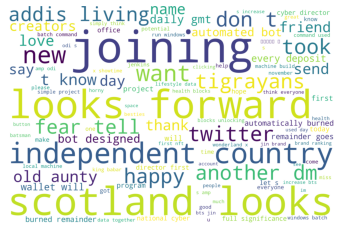

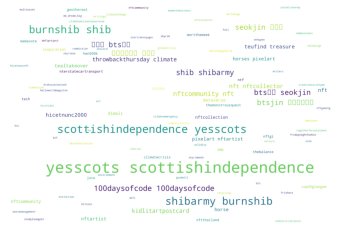

Time taken: 0.15663338502248128 mins


In [29]:
import time

test30 = pd.read_csv("search_30.csv")
start_time = time.time()
word_cloud(test30, query="hello world", save_imgs=False)
end_time = time.time()

print(f"Time taken: {(end_time-start_time)/60} mins")

## Attention over time plots:

Creating a daily track of Tweet volume relevant to a query. Takes the DataFrame from the search functions as an input, and outputs a graph figure.

In [42]:
import pandas as pd
test = pd.read_csv('search_full.csv')

In [43]:
test["created_at"] = pd.to_datetime(test["created_at"])

In [44]:
daily_counts = test.groupby(test["created_at"].dt.date).count()
daily_counts

,Tweet ID,text,attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,referenced_tweets,followers_count,verified,entities_hashtags,retweet_count,reply_count,like_count,quote_count,total_engagements
created_at,,,,,,,,,,,,,,,,,,,,
2021-10-10,2,2,0,2,0,2,2,2,0,0,2,2,2,2,0,2,2,2,2,2
2021-10-13,2,2,0,2,0,2,2,2,0,1,2,2,2,2,2,2,2,2,2,2
2021-10-14,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1
2021-10-16,3,3,2,3,2,3,3,3,0,2,3,3,3,3,3,3,3,3,3,3
2021-10-19,1,1,1,1,0,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1
2021-10-21,1,1,0,1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,1,1
2021-10-22,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1
2021-10-23,4,4,0,4,3,4,4,4,0,1,4,3,4,4,3,4,4,4,4,4
2021-10-25,1,1,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1


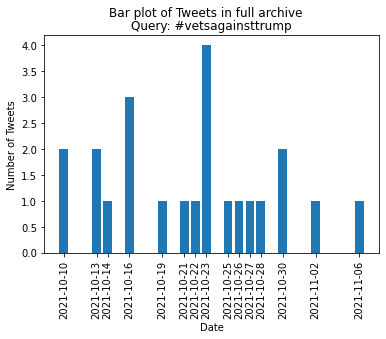

In [46]:
# bar plot
import matplotlib.pyplot as plt

plt.bar(daily_counts.index, daily_counts["text"])
plt.xticks(daily_counts.index, rotation=90)
plt.suptitle("Bar plot of Tweets in full archive", fontsize=12)
plt.title(f"Query: #vetsagainsttrump")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.show()